# Regression and Other Stories: Elections Economy

Predicting presidential vote share from the economy. See Chapters 1, 7, 8, 9, and 22 in Regression and Other Stories.

----

###  Load Packages

In [1]:
using DataFrames, StatsPlots, CSV, HTTP
using Distributions, Turing, MCMCChains, Random
using StatsBase:mad

### Load Data

In [2]:
data = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectionsEconomy/data/hibbs.dat"
hibbs = CSV.File(HTTP.get(data).body, delim=" ") |> DataFrame
first(hibbs, 6)

,year,growth,vote,inc_party_candidate,other_candidate
,Int64,Float64,Float64,String,String
1,1952,2.4,44.6,Stevenson,Eisenhower
2,1956,2.89,57.76,Eisenhower,Stevenson
3,1960,0.85,49.91,Nixon,Kennedy
4,1964,4.21,61.34,Johnson,Goldwater
5,1968,3.02,49.6,Humphrey,Nixon
6,1972,3.62,61.79,Nixon,McGovern


## Graphing the bread and peace model

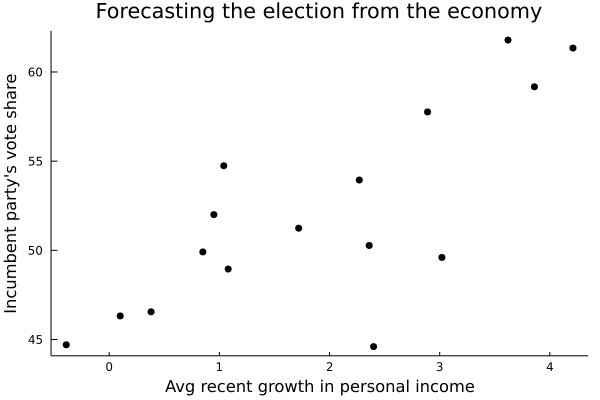

In [3]:
@df hibbs scatter(
    :growth,
    :vote,
    xlabel="Avg recent growth in personal income",
    ylabel="Incumbent party's vote share",
    title="Forecasting the election from the economy",
    color=:black,
    legend=false,
    grid=false
)
# TODO: Strings as markers? Can't find functionality in Plots.jl

## Linear Regression

In [4]:
@model function m1(g, v)
    
    # Variance
    σ ~ truncated(Normal(0,100), 0, Inf)
    
    # Linear
    α ~ Normal(52, 14)
    β ~ Normal(0, 10)
    
    μ = α .+ g * β
    v ~ MvNormal(μ, σ)
end;

In [5]:
model = m1(hibbs[:, :growth], hibbs[:, :vote])
chain = sample(model, NUTS(), 4000)
summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α   46.3820    1.8351     0.0290    0.0411   1687.6175    1.0017    ⋯
           β    3.0037    0.7921     0.0125    0.0184   1475.1822    1.0020    ⋯
           σ    4.1204    0.8789     0.0139    0.0205   1806.5298    0.9998    ⋯
                                                                1 column omitted


### Posterior interval

In [6]:
quantile(chain; q=[0.05,0.95])


Quantiles
  parameters      5.0%     95.0% 
      Symbol   Float64   Float64 

           α   43.4120   49.3964
           β    1.6812    4.2751
           σ    2.9863    5.8138


### Plot Regression Line

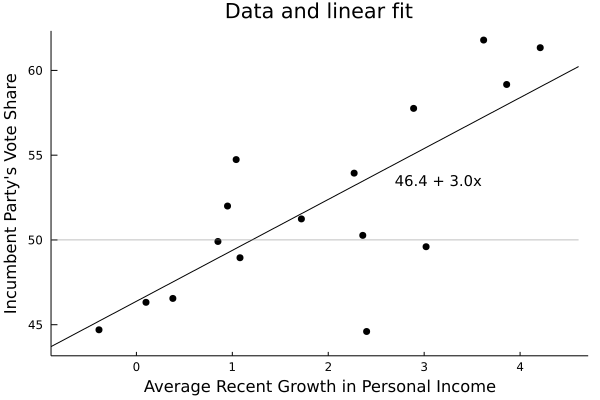

In [7]:
results = get(chain, [:α, :β, :σ]);

@df hibbs scatter(
    :growth,
    :vote,
    xlabel="Average Recent Growth in Personal Income",
    ylabel="Incumbent Party's Vote Share",
    color=:black,
    legend=false,
    title="Data and linear fit",
    grid=false,
    xlim=(minimum(hibbs.growth)-.5,maximum(hibbs.growth)+.5)
)

int = mean(results.α)
slope = mean(results.β)
plot!( 
    (minimum(hibbs.growth)-.5:0.5:maximum(hibbs.growth)+.5),
    (x) -> int + slope * x,
    -.7:4.5,
    color=:black
)
plot!(
    minimum(hibbs.growth)-.5:0.5:maximum(hibbs.growth)+.5,
    x->50,
    color=:gray,
    linewidth=0.5
)
annotate!(2.7,53.5, text(string(round(int,digits=1), " + ", round(slope,digits=1), "x"), :left, 10))

### Plot Prediction Given 2% Growth

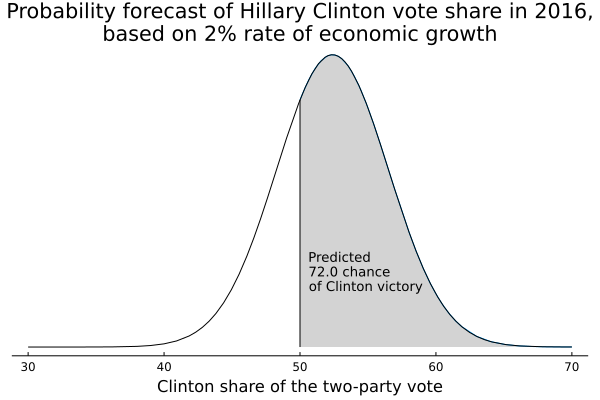

In [8]:
pred_mu = int + slope * 2.0
pred_sigma = mean(results.σ)
victory = round( 100*(cdf(Normal(pred_mu, pred_sigma), Inf) - cdf(Normal(pred_mu, pred_sigma), 50)))

title="Probability forecast of Hillary Clinton vote share in 2016,\nbased on 2% rate of economic growth"
xlabel="Clinton share of the two-party vote"
let n = Normal(pred_mu,pred_sigma), (from,x0,to) = (30,50,70)
    plot(x->pdf(n,x), x0, to, fillrange=0, fill=(0,0.5,"darkgray"),
        legend=false, yaxis=false, yticks=false, grid=false,
        title=title, xlabel=xlabel
    )
    plot!(x->pdf(n,x), from, to, c="black")
    plot!([x0,x0], [0, pdf(n,x0)], c="black")
    annotate!(50.7, 0.025, text("Predicted\n$victory chance\nof Clinton victory",9, :left))
end


### Plot Data and Linear Fit

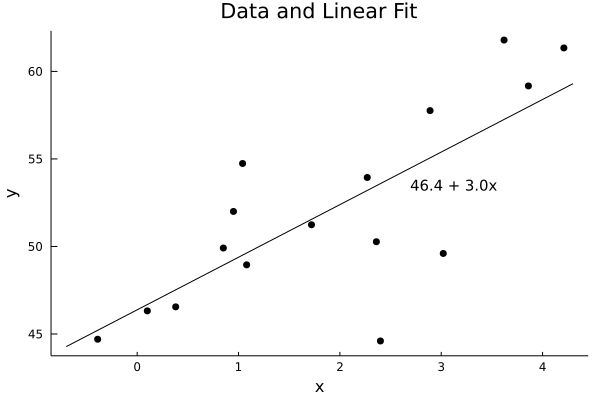

In [9]:
@df hibbs scatter(
    :growth,
    :vote,
    xlabel="x",
    ylabel="y",
    title="Data and Linear Fit",
    color=:black,
    legend=false,
    grid=false
)
plot!( 
    (x) -> int + slope * x,
    -.7:4.5,
    color=:black
)
annotate!(2.7,53.5, text(string(round(int,digits=1), " + ", round(slope,digits=1), "x"), :left, 10))

### Plot data and a range of possible linear fits

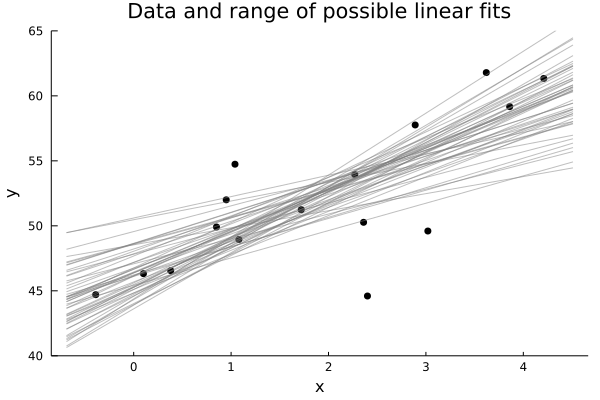

In [10]:
p = @df hibbs scatter(
    :growth,
    :vote,
    xlabel="x",
    ylabel="y",
    label="data",
    title="Data and range of possible linear fits",
    legend=false,
    ylims=(40,65),
    color=:black,
    grid=false
)

for i in rand(1:length(results.α), 50)
    plot!( 
        (x) -> results.α[i] + results.β[i] * x,
        minimum(hibbs[:,:growth])-.3, maximum(hibbs[:,:growth])+.3,
        c="gray50", linealpha=0.5
    )
end
display(p)

## Illustrate computations

### Extract the simulations

In [11]:
sims = get(chain,[:α, :β, :σ])
a = sims.α.data
b = sims.β.data
sigma = sims.σ.data;

### Median and mean absolute deviation (MAD_SD)

In [12]:
med = [median(p) for p in [a,b,sigma]]
MAD_SD = [mad(p) for p in [a,b,sigma]]
d_show = DataFrame([
        :parameter=>["(Intercept)","growth","sigma"],
        :Median=>med,
        :MAD_SD=>MAD_SD,
        ])

,parameter,Median,MAD_SD
,String,Float64,Float64
1,(Intercept),46.3784,1.73137
2,growth,3.02286,0.750182
3,sigma,3.97749,0.777845


### Median and mean absolute deviation (MAD_SD) for a derived quantity a/b

In [13]:
z = a./b
println(median(z))

15.345710716159363


In [14]:
println(mad(z))

4.2570649344905


### Point prediction given 2% growth

In [15]:
new = [2]
mpred = m1(new, missing)
y_point_pred = sample(mpred, NUTS(), 4000)
median(get(y_point_pred, [:v]).v.data);

┌ Info: Found initial step size
│   ϵ = 0.20625000000000002
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


### Alternative way to compute the point prediction

In [16]:
a_hat = median(sims.α.data)
b_hat = median(sims.β.data)
y_point_pred = a_hat .+ b_hat .* new

1-element Vector{Float64}:
 52.42408342150199

### Predictive uncertainty

In [17]:
new_chains = sample(mpred, NUTS(), 4000)
y_pred = get(y_point_pred, [:v]).v.data;

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


LoadError: MethodError: no method matching get(::Vector{Float64}, ::Vector{Symbol})
[0mClosest candidates are:
[0m  get([91m::Base.Iterators.Pairs[39m, ::Any, [91m::Any[39m) at iterators.jl:272
[0m  get([91m::Transducers.GroupByViewDict{var"#s154", var"#s152", S, D} where {var"#s154", var"#s152", D<:(AbstractDict{var"#s154", V} where V)}[39m, ::Any, [91m::Any[39m) where S at C:\Users\tburch\.julia\packages\Transducers\oLdU1\src\groupby.jl:141
[0m  get([91m::DataStructures.SwissDict{K, V}[39m, ::Any, [91m::Any[39m) where {K, V} at C:\Users\tburch\.julia\packages\DataStructures\ixwFs\src\swiss_dict.jl:490
[0m  ...

### Predictive uncertainty manually

In [18]:
n_sims = length(sigma)
y_pred = a .+ b .* fill(new[1], n_sims) .+ rand(Normal(0,median(sigma)), n_sims);

### Summarize predictions

In [19]:
Med = median(y_pred)
MAD_SD = mad(y_pred)
win_prob = mean(y_pred .> 50)
println("Predicted Clinton percentage of 2-party vote: ", round(Med,digits=1),
  ", with s.e. ", round(MAD_SD, digits=1), "\nPr (Clinton win) = ", round(win_prob, digits=2)
    )

Predicted Clinton percentage of 2-party vote: 52.5, with s.e. 4.2
Pr (Clinton win) = 0.72


### Summarize predictions graphically

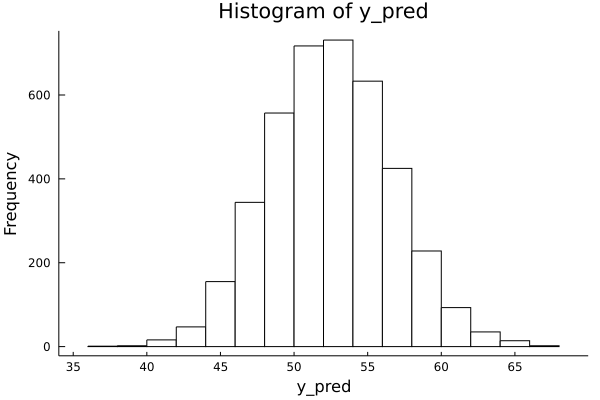

In [20]:
histogram(
    y_pred,
    ylabel="Frequency",
    xlabel="y_pred",
    title="Histogram of y_pred",
    color=:white,
    bins=17,
    label=false,
    grid=false
)

### Predict for many new values

In [21]:
new_grid = [-2.0, 4.0, 0.5]
mpred_grid = m1(new_grid, missing)
c_pred_grid = sample(mpred, NUTS(0.65), 4000);

┌ Info: Found initial step size
│   ϵ = 4.800000000000001
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


### Plots

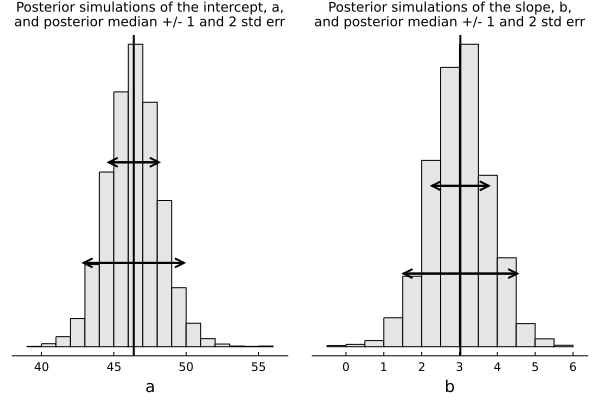

In [22]:
plt= plot(
    histogram(
        a,
        color=:gray90,
        bins=15,
        legend=false,
        yticks=false,
        yaxis=false,
        xlabel="a",
        title="Posterior simulations of the intercept, a,\nand posterior median +/- 1 and 2 std err",
        titlefontsize=9,
        grid=false
        ),
    histogram(
        b,
        color=:gray90,
        bins=15,
        legend=false,
        yticks=false,
        yaxis=false,
        xlabel="b",
        title="Posterior simulations of the slope, b,\nand posterior median +/- 1 and 2 std err",
        titlefontsize=9,
        grid=false
    )
    ,layout = (1, 2)
)
vline!(plt[1], [median(a)], color=:black, linewidth=2)
vline!(plt[2], [median(b)], color=:black, linewidth=2)

# 1 sigma arrows, a
plot!(plt[1],
    [median(a),median(a) .+ 1.483*median(abs.(a .- median(a)))],
    [550,550],
    arrow=true,color=:black,linewidth=2)
plot!(plt[1],
    [median(a),median(a) .- 1.483*median(abs.(a .- median(a)))],
    [550,550],
    arrow=true,color=:black,linewidth=2)

# 2 sigma arrows, a
plot!(plt[1],
    [median(a),median(a) .+ 2*1.483*median(abs.(a .- median(a)))],
    [250,250],
    arrow=true,color=:black,linewidth=2)
plot!(plt[1],
    [median(a),median(a) .- 2*1.483*median(abs.(a .- median(a)))],
    [250,250],
    arrow=true,color=:black,linewidth=2)

# 1 sigma arrows, b
plot!(plt[2],
    [median(b),median(b) .+ 1.483*median(abs.(b .- median(b)))],
    [550,550],
    arrow=true,color=:black,linewidth=2)
plot!(plt[2],
    [median(b),median(b) .- 1.483*median(abs.(b .- median(b)))],
    [550,550],
    arrow=true,color=:black,linewidth=2)

# 2 sigma arrows, b
plot!(plt[2],
    [median(b),median(b) .+ 2*1.483*median(abs.(b .- median(b)))],
    [250,250],
    arrow=true,color=:black,linewidth=2)
plot!(plt[2],
    [median(b),median(b) .- 2*1.483*median(abs.(b .- median(b)))],
    [250,250],
    arrow=true,color=:black,linewidth=2)


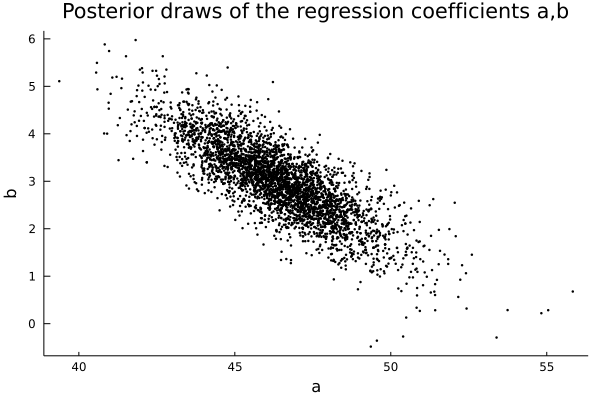

In [23]:
scatter(
    a,b,
    color=:black,
    markersize=1.5,
    xlabel="a",
    ylabel="b",
    title="Posterior draws of the regression coefficients a,b",
    legend=false,
    grid=false
)

### MCMCChains method

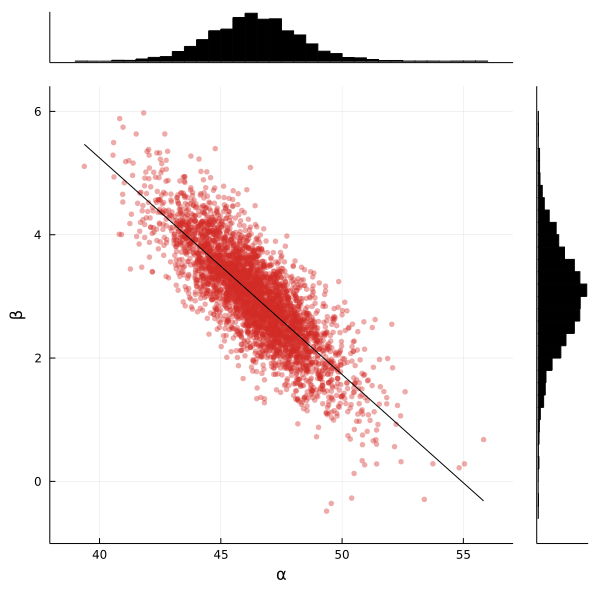

In [24]:
corner(chain, [:α, :β])

### More plotting

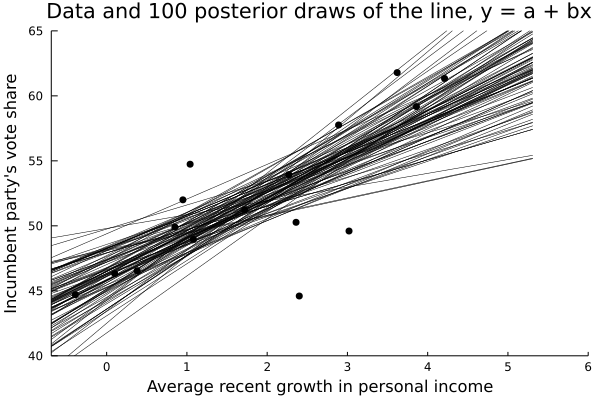

In [25]:
p = @df hibbs scatter(
    :growth,
    :vote,
    xlabel="Average recent growth in personal income",
    ylabel="Incumbent party's vote share",
    title="Data and 100 posterior draws of the line, y = a + bx",
    legend=false,
    ylims=(40,65),
    color=:black,
    xlims=(minimum(hibbs.growth)-0.3, 6),
    markerstrokecolor=:black,
    grid=false
)

for i in 1:100
    plot!(
        minimum(hibbs.growth)-0.3:6,
        x -> a[i] + b[i] * x,
        linewidth=0.5,
        color=:black
    )
end

display(p)

### Add more uncertainty

In [26]:
x = rand(Normal(2.0, 0.3), n_sims)
y_hat = a .+ b .* x
y_pred = rand.(Normal.(y_hat, sigma))

Median = median(y_pred)
MAD_SD = 1.483 * median(abs.(y_pred .- median(y_pred)))
win_prob = mean(y_pred .> 50)
println(
    "Predicted Clinton percentage of 2-party vote: ", round(Median, digits=1), ",
  with s.e. ", round(MAD_SD, digits=1), "\nPr (Clinton win) = ", round(win_prob, digits=2)
)

Predicted Clinton percentage of 2-party vote: 52.4,
  with s.e. 4.1
Pr (Clinton win) = 0.72


### More plotting

In [27]:
ceil(maximum(y_pred))

75.0

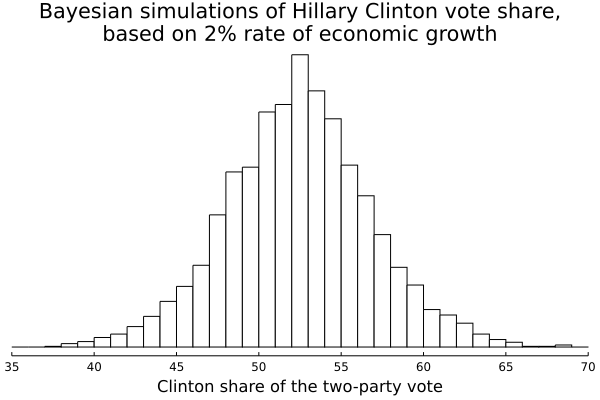

In [28]:
histogram(
    y_pred,
    bins=floor(minimum(y_pred)):1:ceil(maximum(y_pred)),
    xlim=(35,70),
    color=:white,
    grid=false,
    yaxis=false,
    yticks=false,
    legend=false,
    title="Bayesian simulations of Hillary Clinton vote share,\nbased on 2% rate of economic growth",
    xlabel="Clinton share of the two-party vote"
    )

### Bayesian inference and prior information

Combining information from a forecast and a poll. Hypothetical forecast and data.

In [29]:
theta_hat_prior = 0.524
se_prior = 0.041

n = 400
y = 190
theta_hat_data = y/n
se_data = sqrt( (y/n) * (1-y/n)/n )

theta_hat_bayes = (theta_hat_prior / se_prior^2 + theta_hat_data / se_data^2) /
  (1 / se_prior^2 + 1 / se_data^2)

se_bayes = sqrt(1/(1/se_prior^2 + 1/se_data^2));

### Ramp up the data variance

In [30]:
se_data = 0.075

println((theta_hat_prior/se_prior^2 + theta_hat_data/se_data^2)/(1/se_prior^2 + 1/se_data^2))

0.5127258417738846


### Comparison to `lm()`

In [31]:
using GLM

In [32]:
results_lm = lm(@formula(vote ~ growth), hibbs)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

vote ~ 1 + growth

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  46.2476     1.62193   28.51    <1e-13   42.769     49.7263
growth        3.06053    0.696274   4.40    0.0006    1.56717    4.55389
────────────────────────────────────────────────────────────────────────